In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Check values for all numbers (excluding performance metrics) used in the paper

### SCRIPT train/val/test

Raw data

In [14]:
EDW_DIR = '../../../CarpeDiem Extubation Prediction Sam Alec/data/edw_redacted'

In [15]:
edw_raw = pd.read_csv(f'{EDW_DIR}/edw_full_annotated.csv',index_col=0)

In [16]:
len(edw_raw)

16402

In [17]:
print("Unfiltered stats")
print(f"Number of ICU days: {len(edw_raw)}")
print(f"Number of patients: {edw_raw.pt_study_id.nunique()}")
print(f"Number of ICU stays: {edw_raw.Patient_id_2.nunique()}")

Unfiltered stats
Number of ICU days: 16402
Number of patients: 712
Number of ICU stays: 940


In [18]:
edw_raw.extubation_status.value_counts()

extubation_status
intubated              12333
preintubated            1892
extubated               1516
dni transplant           362
failed                   125
dni                      109
same-day fail             40
suspected dni             13
ECMO non-successful        9
early extubation           3
Name: count, dtype: int64

Get latest data point

Trimmed data as presented to models

In [21]:
auto_train = pd.read_csv(f'{EDW_DIR}/train.csv')
auto_val = pd.read_csv(f'{EDW_DIR}/val.csv')
auto_test = pd.read_csv(f'{EDW_DIR}/test.csv')
auto_fail = pd.read_csv(f'{EDW_DIR}/fail.csv')
auto_trach = pd.read_csv(f'{EDW_DIR}/trach.csv')

In [22]:
auto_train['dataset'] = 'train'
auto_val['dataset'] = 'val'
auto_test['dataset'] = 'test'
auto_fail['dataset'] = 'fail'
auto_trach['dataset'] = 'trach'

all_auto = pd.concat([auto_train,auto_val,auto_test,auto_fail,auto_trach])

In [23]:
all_auto['pt_study_id'] = [x.split('/')[0] for x in all_auto.Patient_id_2]

In [24]:
print("Filtered stats")
print(f"Number of ICU days: {len(all_auto)}")
print(f"Number of patients: {all_auto.pt_study_id.nunique()}")
print(f"Number of ICU stays: {all_auto.Patient_id_2.nunique()}")

Filtered stats
Number of ICU days: 9828
Number of patients: 696
Number of ICU stays: 781


## CDH

Unfiltered

In [25]:
CDH_DIR = '../../../CarpeDiem Extubation Prediction Sam Alec/data/cdh_redacted'

In [26]:
cdh_raw = pd.read_csv(f'{CDH_DIR}/cdh_full_annotated.csv',index_col=0)

In [27]:
cdh_raw.shape

(5814, 55)

In [28]:
cdh_raw.extubation_status.value_counts()

extubation_status
intubated           4158
preintubated         787
extubated            778
failed                36
suspected dni         35
same-day fail         13
early extubation       6
early intubation       1
Name: count, dtype: int64

In [29]:
print("Unfiltered stats")
print(f"Number of ICU days: {len(cdh_raw)}")
print(f"Number of patients: {cdh_raw.visit_key.nunique()}")
print(f"Number of ICU stays: {cdh_raw.Patient_id_2.nunique()}")

Unfiltered stats
Number of ICU days: 5814
Number of patients: 459
Number of ICU stays: 518


Trimmed data as presented to models

In [30]:
cdh_full = pd.read_csv(f"{CDH_DIR}/full.csv",index_col=0)
cdh_fail = pd.read_csv(f"{CDH_DIR}/fail.csv",index_col=0)
cdh_trach = pd.read_csv(f"{CDH_DIR}/trach.csv",index_col=0)

In [31]:
cdh_full['Patient_id'] = [x.split('/')[0] for x in cdh_full.Patient_id_2]

In [32]:
print("Filtered stats")
print(f"Number of ICU days: {len(cdh_full)}")
print(f"Number of patients: {cdh_full.Patient_id.nunique()}")
print(f"Number of ICU stays: {cdh_full.Patient_id_2.nunique()}")

Filtered stats
Number of ICU days: 2835
Number of patients: 333
Number of ICU stays: 349


## Get fail rate in both SCRIPT and CDH datasets

Need to get the SCRIPT dataset that's properly labelled with next-day extubation status

In [33]:
edw_list = []

for patient in edw_raw['Patient_id_2'].unique():
    sub = edw_raw[edw_raw['Patient_id_2'] == patient]
    labels = list(sub['Intubation_flag'][1:])
    next_day_ext_status = list(sub['extubation_status'][1:])
    features = sub.iloc[:-1,:]
    features['labels'] = labels
    features['next_day_extubation_status'] = next_day_ext_status
    edw_list.append(features)

edw_next_day = pd.concat(edw_list, ignore_index=False)

In [34]:
edw_next_day.next_day_extubation_status.value_counts(dropna=False)

next_day_extubation_status
intubated              12185
extubated               1516
preintubated            1104
dni transplant           358
failed                   125
dni                      109
same-day fail             40
suspected dni             13
ECMO non-successful        9
early extubation           3
Name: count, dtype: int64

In [35]:
def fail_rate(df,flag_col='Intubation_flag'):
    cts = df[(df[flag_col] == 1) & (df.labels == 0)].next_day_extubation_status.value_counts()
    fails = np.sum(cts[cts.index.isin(['failed','same-day fail'])].values)
    extub = np.sum(cts[cts.index.isin(['extubated','early extubation'])].values)
    print(f"{fails}/{fails+extub} fails --> {100 * fails/(fails+extub)}%")
    return

In [36]:
fail_rate(edw_next_day)

139/603 fails --> 23.051409618573796%


CDH

In [37]:
cdh_list = []

for patient in cdh_raw['Patient_id_2'].unique():
    sub = cdh_raw[cdh_raw['Patient_id_2'] == patient]
    labels = list(sub['Intubation_flag'][1:])
    next_day_ext_status = list(sub['extubation_status'][1:])
    features = sub.iloc[:-1,:]
    features['labels'] = labels
    features['next_day_extubation_status'] = next_day_ext_status
    cdh_list.append(features)

cdh_next_day = pd.concat(cdh_list, ignore_index=False)

In [38]:
cdh_next_day.next_day_extubation_status.value_counts(dropna=False)

next_day_extubation_status
intubated           3938
extubated            778
preintubated         489
failed                36
suspected dni         35
same-day fail         13
early extubation       6
early intubation       1
Name: count, dtype: int64

In [39]:
fail_rate(cdh_next_day)

41/260 fails --> 15.76923076923077%


## Breakdown of days

In [40]:
cdh_raw['dataset'] = 'CDH'
edw_raw['dataset'] = 'SCRIPT'

In [41]:
combined = pd.concat([cdh_raw,edw_raw])

In [42]:
combined.extubation_status.value_counts()

extubation_status
intubated              16491
preintubated            2679
extubated               2294
dni transplant           362
failed                   161
dni                      109
same-day fail             53
suspected dni             48
early extubation           9
ECMO non-successful        9
early intubation           1
Name: count, dtype: int64

In [43]:
merge_extub = {
    'dni':'CMO',
    'suspected dni':'CMO',
    'ECMO non-successful':'CMO',
    'failed':'fail',
    'same-day fail':'fail',
    'early intubation':'preintubated',
    'early extubation':'extubated'
}

combined['new_extubation_status'] = [merge_extub[x] if x in merge_extub.keys() else x for x in combined.extubation_status]

In [44]:
combined['new_extubation_status'].value_counts()

new_extubation_status
intubated         16491
preintubated       2680
extubated          2303
dni transplant      362
fail                214
CMO                 166
Name: count, dtype: int64

In [45]:
def dataset_breakdown(patient):
    if patient in list(edw_raw.Patient_id_2):
        if patient in list(auto_train.Patient_id_2):
            return "SCRIPT train"
        elif patient in list(auto_val.Patient_id_2):
            return "SCRIPT val"
        elif patient in list(auto_test.Patient_id_2):
            return "SCRIPT test"
        elif patient in list(auto_fail.Patient_id_2):
            return "SCRIPT fail"
        elif patient in list(auto_trach.Patient_id_2):
            return "SCRIPT trach"
        else:
            return "SCRIPT filtered"
    elif patient in list(cdh_raw.Patient_id_2):
        if patient in list(cdh_full.Patient_id_2):
            return 'CDH eval'
        elif patient in list(cdh_fail.Patient_id_2):
            return 'CDH fail'
        elif patient in list(cdh_trach.Patient_id_2):
            return 'CDH trach'
        else:
            return 'CDH filtered'
    else:
        print(f"missing {patient}")
        return

In [46]:
combined['dataset_2'] = [dataset_breakdown(p) for p in combined.Patient_id_2]

In [47]:
combined.drop_duplicates(subset='Patient_id_2')['dataset_2'].value_counts(dropna=False)

dataset_2
CDH eval           349
SCRIPT train       305
SCRIPT trach       253
SCRIPT filtered    159
CDH filtered       106
SCRIPT test         97
SCRIPT val          76
SCRIPT fail         50
CDH trach           33
CDH fail            30
Name: count, dtype: int64

In [48]:
FIGURES_DIR = '../results'

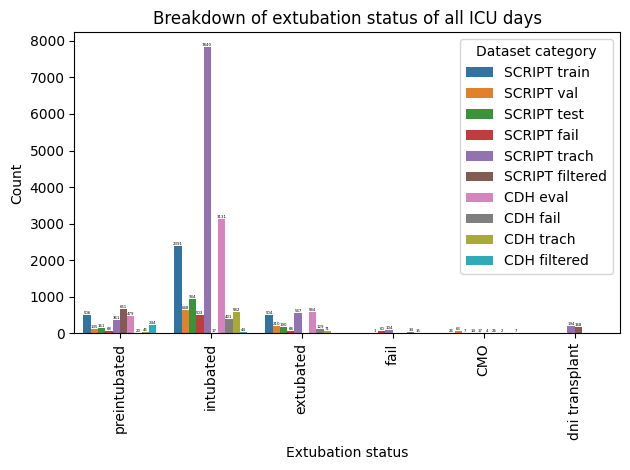

In [50]:
source_order = ['SCRIPT train','SCRIPT val','SCRIPT test','SCRIPT fail','SCRIPT trach','SCRIPT filtered',
               'CDH eval','CDH fail','CDH trach','CDH filtered']
ax = sns.countplot(data=combined,x='new_extubation_status',hue='dataset_2',hue_order=source_order)
plt.xticks(rotation=90)

for container in ax.containers:
    ax.bar_label(container,fontsize=2.8)
plt.xlabel('Extubation status')
plt.ylabel('Count')
plt.title('Breakdown of extubation status of all ICU days')
plt.legend(title='Dataset category',loc='upper right')
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/ICU_day_breakdown_new.pdf')
plt.show()

## Histogram of extubation times

In [3]:
intubs = pd.read_csv(intubs_path)

In [4]:
intubs.RECORDED_TIME = pd.to_datetime(intubs.RECORDED_TIME)
intubs = intubs.sort_values(['pt_study_id', 'RECORDED_TIME', 'MEAS_VALUE'])

In [5]:
first_check = ((intubs.DISP_NAME == 'Extubation') & (intubs.MEAS_VALUE == 'Yes'))
second_check = (intubs.DISP_NAME == 'Vent D/C')

ext = intubs.loc[first_check | second_check].drop_duplicates(subset=['pt_study_id','RECORDED_TIME'])

In [6]:
times = pd.DatetimeIndex(ext.RECORDED_TIME.values)
ext['recorded_time_plot'] = [x.time() for x in times]

# Convert time objects to minutes since midnight
ext['time_of_day'] = ext['recorded_time_plot'].apply(lambda t: t.hour * 60 + t.minute)

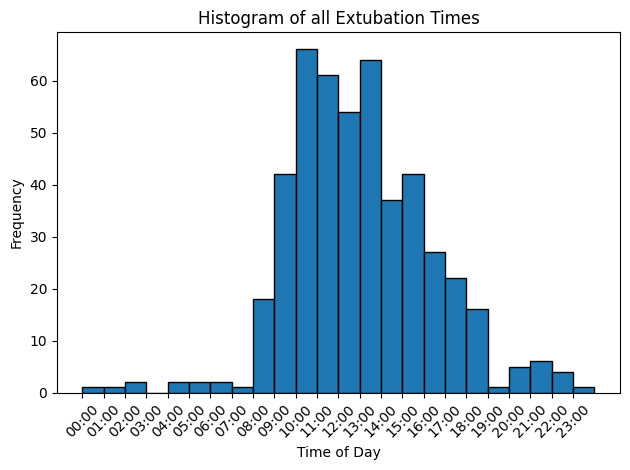

In [13]:
bin_edges = range(0, 24*60 + 1, 60)
plt.hist(ext['time_of_day'], bins=bin_edges, edgecolor='black')
plt.xlabel('Time of Day')
plt.ylabel('Frequency')
plt.title('Histogram of all Extubation Times')
plt.xticks(range(0, 24*60, 60), [f'{h:02d}:00' for h in range(24)], rotation=45)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/extubation_times.pdf')
plt.show()

In [9]:
before_8am = ext[ext.time_of_day < 480].sort_values(by='recorded_time_plot')

In [10]:
len(before_8am)/len(ext)

0.023060796645702306